### Statistical Analysis and visualisations

In [55]:
import pandas as pd
from scipy.stats import shapiro, ttest_rel, wilcoxon
import re
import math

### Loading Datasets

In [56]:
# 1) Load your merged extended data
df = pd.read_csv(r'F:\01_Academic\Disseration\Post_EXP\Preprocessing\Participant_Vector_Data\Participant_Single_Vector_Data_Extended')

In [57]:
# 2) Drop any missing
df = df.dropna(subset=['prop_left_1','prop_left_2','language_group'])

In [58]:
# 1a. Clean up the language labels
df['language_group'] = (
    df['language_group']
      .str.strip()            # remove leading/trailing whitespace
      .str.title()            # unify to Title Case (“Hindi”, “Arabic”)
)

# (Optional) check you only have two unique groups now
print(df['language_group'].unique())

['Hindi' 'Arabic']


### Means and Averages

In [59]:
# 2. Define your grouping variable
grouped = df.groupby('language_group')

# 3. Compute means for prop_left_1 … prop_left_6
prop_cols = [f'prop_left_{i}' for i in range(1, 7)]
prop_means = grouped[prop_cols].mean()
print('Mean prop_left by language group:')
print(prop_means)

# 4. Compute means for err_pct_Q1–Q4 across mat1–mat3
err_cols = [f'err_pct_Q{q}_mat{m}' for q in range(1, 5) for m in range(1, 4)]
err_means = grouped[err_cols].mean()
print('\nMean error percentages (Q1–Q4) by mat1–mat3 and language group:')
print(err_means)

# 5. Compute means for all other per‐material columns
#    (anything ending in _mat1, _mat2 or _mat3 except err_pct we already did)
all_mat_cols = [col for col in df.columns if re.search(r'_mat[123]$', col)]
other_mat_cols = [col for col in all_mat_cols if not col.startswith('err_pct')]
other_means = grouped[other_mat_cols].mean()
print('\nMean of all other _mat1–_mat3 columns by language group:')
print(other_means)

# 6. (Optional) If you’d like to see each material set separately:
for m in [1, 2, 3]:
    cols_m = [col for col in all_mat_cols if col.endswith(f'_mat{m}')]
    means_m = grouped[cols_m].mean()
    print(f'\n=== Material set {m} means ===')
    print(means_m)


Mean prop_left by language group:
                prop_left_1  prop_left_2  prop_left_3  prop_left_4  \
language_group                                                       
Arabic             0.487142     0.524115     0.390387     0.587230   
Hindi              0.412099     0.493435     0.468015     0.498613   

                prop_left_5  prop_left_6  
language_group                            
Arabic             0.540711     0.543091  
Hindi              0.504993     0.476864  

Mean error percentages (Q1–Q4) by mat1–mat3 and language group:
                err_pct_Q1_mat1  err_pct_Q1_mat2  err_pct_Q1_mat3  \
language_group                                                      
Arabic                25.597426        89.222222        38.892663   
Hindi                 58.757149        68.907407        49.716938   

                err_pct_Q2_mat1  err_pct_Q2_mat2  err_pct_Q2_mat3  \
language_group                                                      
Arabic                87.875000  

### Statistical Testing

In [60]:
results = []
for lang in df['language_group'].unique():
    sub = df[df['language_group']==lang]
    # compute within-subject difference
    factor_1 = "prop_left_1"
    factor_2 = "prop_left_4"
    diff = sub[factor_1] - sub[factor_2]
    # normality check
    stat_s, p_s = shapiro(diff)
    if p_s > 0.05:
        stat_t, p_t = ttest_rel(sub[factor_1], sub[factor_2])
        test_name = 'Paired t-test'
    else:
        stat_t, p_t = wilcoxon(sub[factor_1], sub[factor_2])
        test_name = 'Wilcoxon signed-rank'
    # collect results
    results.append({
        'language_group': lang,
        'n': len(sub),
        'shapiro_p': p_s,
        'test': test_name,
        'statistic': stat_t,
        'p_value': p_t,
        'mean_4': sub[factor_1].mean(),
        'sd_4': sub[factor_1].std(),
        'mean_5': sub[factor_2].mean(),
        'sd_5': sub[factor_2].std()
    })

results_df = pd.DataFrame(results)
print(results_df)


  language_group   n  shapiro_p           test  statistic   p_value    mean_4  \
0          Hindi  12   0.308242  Paired t-test  -2.045850  0.065442  0.412099   
1         Arabic   4   0.442673  Paired t-test  -0.928702  0.421547  0.487142   

       sd_4    mean_5      sd_5  
0  0.167243  0.498613  0.074348  
1  0.167332  0.587230  0.096691  


### MS 

In [61]:
results = []
sub = pd.read_csv(r'F:\01_Academic\Disseration\Post_EXP\Preprocessing\Auditory_Speech_Task\High-Level_Feature_Extraction\Auditory_Speech_High-Level_Features')
# compute within-subject difference
factor_1 = "leftward_ms"
factor_2 = "rightward_ms"
diff = sub[factor_1] - sub[factor_2]
# normality check
stat_s, p_s = shapiro(diff)
if p_s > 0.05:
    stat_t, p_t = ttest_rel(sub[factor_1], sub[factor_2])
    test_name = 'Paired t-test'
else:
    stat_t, p_t = wilcoxon(sub[factor_1], sub[factor_2])
    test_name = 'Wilcoxon signed-rank'
# collect results
results.append({
    'statistic': stat_t,
    'p_value': p_t,
    'leftward_ms': sub[factor_1].mean(),
    'sd_leftward': sub[factor_1].std(),
        'mean_rightward': sub[factor_2].mean(),
        'sd_rightward': sub[factor_2].std()
})

results_df = pd.DataFrame(results)
print(results_df)

   statistic   p_value  leftward_ms  sd_leftward  mean_rightward  sd_rightward
0     2672.0  0.116005    78.947368    70.493562       78.219298      66.38714


In [63]:
import pandas as pd
import numpy as np
from scipy.stats import shapiro, ttest_rel, wilcoxon

# ——— define your group mappings ———
arabic_ptp_num = {
    "01": "3", "02": "4", "03": "8", "04": "14", "05": "15"
}
hindi_ptp_num = {
    "01": "1",  "02": "2",  "03": "5",  "04": "6",  "05": "7",
    "06": "9",  "07": "10", "08": "11", "09": "12", "10": "13",
    "11": "16", "12": "17", "13": "18", "14": "19"
}

arabic_ids = set(arabic_ptp_num.values())
hindi_ids  = set(hindi_ptp_num.values())

# ——— clean & normalise participant IDs ———
# ensure participant_id is string and strip whitespace
sub['participant_id'] = sub['participant_id'].astype(str).str.strip()

# ——— create the language-group column via mapping ———
sub['group'] = np.where(
    sub['participant_id'].isin(arabic_ids), 'Arabic',
    np.where(sub['participant_id'].isin(hindi_ids), 'Hindi', 'Other')
)

# ——— function to run paired comparison & summarise ———
def paired_compare(df, col1, col2):
    diff     = df[col1] - df[col2]
    stat_s, p_s = shapiro(diff.dropna())
    if p_s > 0.05:
        stat_t, p_t = ttest_rel(df[col1], df[col2], nan_policy='omit')
        test_name   = 'Paired t-test'
    else:
        stat_t, p_t = wilcoxon(df[col1], df[col2], nan_policy='omit')
        test_name   = 'Wilcoxon signed-rank'
    return {
        'test'              : test_name,
        'statistic'         : stat_t,
        'p_value'           : p_t,
        f'mean_{col1}'      : df[col1].mean(),
        f'sd_{col1}'        : df[col1].std(),
        f'mean_{col2}'      : df[col2].mean(),
        f'sd_{col2}'        : df[col2].std()
    }

# ——— loop over each group plus the full cohort ———
results = []
for grp in ['Arabic', 'Hindi', 'All']:
    if grp == 'All':
        df_grp = sub
    else:
        df_grp = sub[sub['group'] == grp]
    res = paired_compare(df_grp, 'leftward_ms', 'rightward_ms')
    res['group'] = grp
    results.append(res)

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))


                test   statistic  p_value  mean_leftward_ms  sd_leftward_ms  mean_rightward_ms  sd_rightward_ms  group
       Paired t-test    1.996893 0.055298         54.200000       31.180675          48.433333        33.303912 Arabic
Wilcoxon signed-rank 1598.000000 0.510225         87.785714       78.264776          88.857143        71.954829  Hindi
Wilcoxon signed-rank 2672.000000 0.116005         78.947368       70.493562          78.219298        66.387140    All


### Auditory Speech Task


=== 2 × 6 mixed ANOVA (Type-III, arcsine data) ===
                                  sum_sq    df           F        PR(>F)
Intercept                       3.319581   1.0  100.080372  4.589551e-15
C(language_group)               0.010118   1.0    0.305045  5.825217e-01
C(condition)                    0.178761   5.0    1.077876  3.803259e-01
C(participant_id)               1.505413  15.0    3.025728  9.136201e-04
C(language_group):C(condition)  0.102345   5.0    0.617109  6.871324e-01
Residual                        2.288672  69.0         NaN           NaN

=== Tukey Hindi vs Arabic inside each condition ===
                       Multiple Comparison of Means - Tukey HSD, FWER=0.05                       
             group1                          group2             meandiff p-adj lower upper reject
-------------------------------------------------------------------------------------------------
       Arabic_English congruent      Arabic_English incongruent  -0.1651   nan   nan   nan

C:\Users\Tommy T\AppData\Local\Temp\ipykernel_18168\1603195097.py:54: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = (long.groupby(["language_group","condition"])


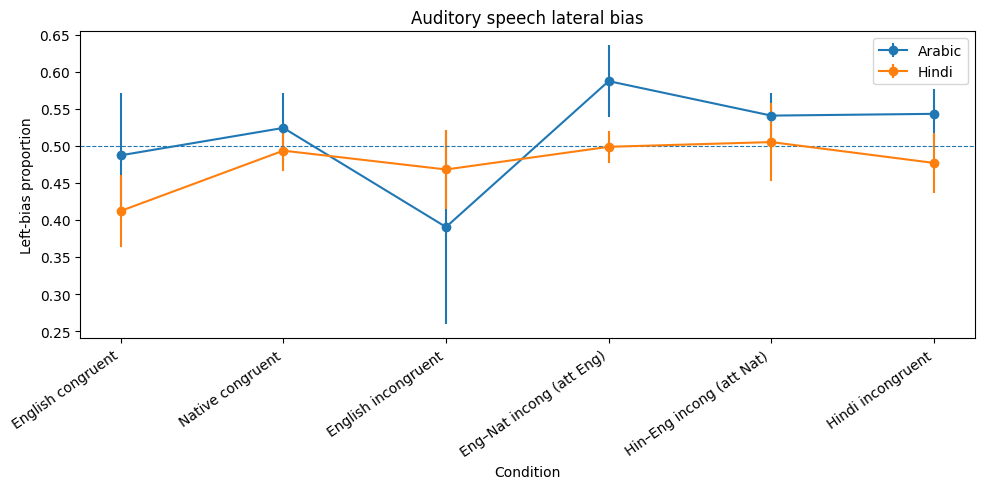

In [ ]:
import pandas as pd, numpy as np, statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
import math, matplotlib.pyplot as plt

# 1.  Load & tidy -------------------------------------------------
df["language_group"] = df["language_group"].str.strip().str.title()
if "participant_id" not in df.columns:
    df["participant_id"] = np.arange(len(df))

cond_map = {
    "prop_left_1": "English congruent",
    "prop_left_2": "Native congruent",
    "prop_left_3": "English incongruent",
    "prop_left_4": "Eng–Nat incong (att Eng)",
    "prop_left_5": "Hin–Eng incong (att Nat)",
    "prop_left_6": "Hindi incongruent",
}

long = (df.melt(id_vars=["participant_id", "language_group"],
                value_vars=list(cond_map.keys()),
                var_name="orig", value_name="left_prop")
          .assign(condition=lambda d: d["orig"].map(cond_map))
          .drop(columns="orig"))

long["condition"] = pd.Categorical(long["condition"],
                                   categories=list(cond_map.values()),
                                   ordered=True)

# arcsine–sqrt (safer for proportions) ---------------------------
eps = 1e-5
long["left_asin"] = np.arcsin(
    np.sqrt(np.clip(long["left_prop"], eps, 1 - eps))
)

# 2.  Fit OLS with Subject factor (+ nested in Language) ---------
#     (SPSS GLM syntax does the same)
ols = smf.ols(
    "left_asin ~ C(language_group) * C(condition) + C(participant_id)",
    data=long
).fit()

aov = anova_lm(ols, typ=3)       # Type-III sums of squares
print("\n=== 2 × 6 mixed ANOVA (Type-III, arcsine data) ===")
print(aov[["sum_sq","df","F","PR(>F)"]])

# 3.  Optional pair-wise simple effects --------------------------
from statsmodels.stats.multicomp import pairwise_tukeyhsd
long["group"] = long["language_group"] + "_" + long["condition"].astype(str)
post = pairwise_tukeyhsd(long["left_asin"], long["group"])
print("\n=== Tukey Hindi vs Arabic inside each condition ===")
print(post.summary())

# 4.  Plot raw means ± SEM ---------------------------------------
summary = (long.groupby(["language_group","condition"])
                 .agg(mean=("left_prop","mean"),
                      sem=("left_prop",
                           lambda x: x.std(ddof=1)/math.sqrt(len(x))))
                 .reset_index())
plt.figure(figsize=(10,5))
for grp in summary["language_group"].unique():
    sub = summary[summary["language_group"]==grp]
    plt.errorbar(sub["condition"], sub["mean"], yerr=sub["sem"],
                 marker="o", ls="-", label=grp)
plt.axhline(0.5, ls="--", lw=.8); plt.ylabel("Left-bias proportion")
plt.xticks(rotation=35, ha="right"); plt.xlabel("Condition")
plt.title("Auditory speech lateral bias"); plt.legend(); plt.tight_layout(); plt.show()


### Omissions 

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm

# 1. Load & clean --------------------------------------------------
df['language_group'] = df['language_group'].str.strip().str.title()
if 'participant_id' not in df.columns:
    df['participant_id'] = np.arange(len(df))

# 2. Compute Left/Right omission means per matrix -----------------
for m in [1, 2, 3]:
    df[f'err_left_mat{m}']  = df[[f'err_pct_Q1_mat{m}', f'err_pct_Q3_mat{m}']].mean(axis=1)
    df[f'err_right_mat{m}'] = df[[f'err_pct_Q2_mat{m}', f'err_pct_Q4_mat{m}']].mean(axis=1)

# 3. Melt to long for ANOVA ----------------------------------------
rows = []
for m in [1, 2, 3]:
    for hemi, col in [('Left',  f'err_left_mat{m}'),
                      ('Right', f'err_right_mat{m}')]:
        tmp = df[['participant_id', 'language_group', col]].copy()
        tmp['matrix']    = m
        tmp['hemispace'] = hemi
        tmp.rename(columns={col: 'err_mean'}, inplace=True)
        rows.append(tmp)
long = pd.concat(rows, ignore_index=True)

# 4. Print the 12 cell means ---------------------------------------
means = (long
         .groupby(['language_group','hemispace','matrix'])
         ['err_mean']
         .mean()
         .unstack(['hemispace','matrix']))
print('\nAverage omission % by Language × Hemispace × Matrix:')
print(means.round(2))

# 5. Transform to proportion & arcsine-sqrt -----------------------
long['err_prop'] = long['err_mean'] / 100
eps = 1e-5
long['err_asin'] = np.arcsin(np.sqrt(np.clip(long['err_prop'], eps, 1-eps)))

# 6. 2×2×3 mixed ANOVA via OLS + Subject as factor -----------------
formula = 'err_asin ~ C(language_group) * C(hemispace) * C(matrix) + C(participant_id)'
model   = smf.ols(formula, data=long).fit()
aov = anova_lm(model, typ=3)

print('\n=== 2×2×3 mixed ANOVA (Type-III SS, arcsine-sqrt DV) ===')
print(aov[['sum_sq','df','F','PR(>F)']].round({
    'sum_sq': 3,
    'df':      0,
    'F':       3,
    'PR(>F)':  4
}))



Average omission % by Language × Hemispace × Matrix:
hemispace        Left                Right             
matrix              1      2      3      1     2      3
language_group                                         
Arabic          35.64  62.64  30.75  93.37  56.5  85.75
Hindi           56.15  70.64  51.99  81.18  59.7  74.27

=== 2×2×3 mixed ANOVA (Type-III SS, arcsine-sqrt DV) ===
                                          sum_sq    df       F  PR(>F)
Intercept                                  2.408   1.0  28.895  0.0000
C(language_group)                          0.046   1.0   0.547  0.4622
C(hemispace)                               1.043   1.0  12.515  0.0007
C(matrix)                                  0.307   2.0   1.844  0.1658
C(participant_id)                          0.634  15.0   0.507  0.9288
C(language_group):C(hemispace)             0.194   1.0   2.327  0.1317
C(language_group):C(matrix)                0.033   2.0   0.199  0.8198
C(hemispace):C(matrix)                  

Subjective epicenter

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats

# 1. Load & tidy
df['language_group'] = df['language_group'].str.strip().str.title()

# 2. Define the “true center” of the screen
#    If your epicenter_x values are offsets from center, use 0.
#    Otherwise, set this to your pixel coordinate (e.g. 512).
center_x = 960  

# 3. Run one‐sample t‐tests per group × matrix
results = []
for group in df['language_group'].unique():
    sub = df[df['language_group'] == group]
    for m in (1, 2, 3):
        col = f'epicenter_x_mat{m}'
        data = sub[col].dropna()
        if len(data) < 2:
            continue
        mean_ = data.mean()
        sd_   = data.std(ddof=1)
        t_stat, p_val = stats.ttest_1samp(data, popmean=center_x)
        results.append({
            'Language':     group,
            'Matrix':       m,
            'N':            len(data),
            'Mean_x':       mean_,
            'SD_x':         sd_,
            't':            t_stat,
            'p (two‐sided)':p_val
        })

res_df = pd.DataFrame(results)
print(res_df.round({
    'Mean_x':       2,
    'SD_x':         2,
    't':            2,
    'p (two‐sided)':4
}))


  Language  Matrix   N   Mean_x    SD_x      t  p (two‐sided)
0    Hindi       1  12   720.46  338.64  -2.45         0.0322
1    Hindi       2  12  1119.76  265.73   2.08         0.0614
2    Hindi       3  12   835.44  260.96  -1.65         0.1265
3   Arabic       1   4   527.90   67.35 -12.83         0.0010
4   Arabic       2   4  1021.06  194.53   0.63         0.5747
5   Arabic       3   4   669.29  189.41  -3.07         0.0546


In [ ]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm

# 1. Load & clean -------------------------------------------------------
df['language_group'] = df['language_group'].str.strip().str.title()
if 'participant_id' not in df.columns:
    df['participant_id'] = np.arange(len(df))

# 2. Melt epicenters to long --------------------------------------------
long = df.melt(id_vars=['participant_id','language_group'],
               value_vars=[f'epicenter_x_mat{m}' for m in (1,2,3)],
               var_name='orig', value_name='epicenter_x')

# 3. Extract matrix number & factorise ---------------------------------
long['matrix'] = long['orig'].str.extract(r'mat(\d)').astype(int)
long.drop(columns='orig', inplace=True)
long['matrix'] = pd.Categorical(long['matrix'], categories=[1,2,3], ordered=True)

# 4. Descriptives -------------------------------------------------------
desc = (long
        .groupby(['language_group','matrix'])['epicenter_x']
        .agg(['mean','std','count'])
        .rename(columns={'mean':'M','std':'SD','count':'N'}))
print('\nSubjective epicenter X by Language × Matrix:')
print(desc.round(2))

# 5. Mixed 2×3 ANOVA via OLS + Subject factor -------------------------
#    Use participant_id as a fixed effect to block within-subjects.
formula = 'epicenter_x ~ C(language_group) * C(matrix) + C(participant_id)'
model   = smf.ols(formula, data=long).fit()
aov     = anova_lm(model, typ=3)

print('\n=== 2×3 mixed ANOVA (Type-III SS) on epicenter_x ===')
print(aov[['sum_sq','df','F','PR(>F)']].round({
    'sum_sq': 3,
    'df':      0,
    'F':       3,
    'PR(>F)':  4
}))



Subjective epicenter X by Language × Matrix:
                             M      SD   N
language_group matrix                     
Arabic         1        527.90   67.35   4
               2       1021.06  194.53   4
               3        669.29  189.41   4
Hindi          1        720.46  338.64  12
               2       1119.76  265.73  12
               3        835.44  260.96  12

=== 2×3 mixed ANOVA (Type-III SS) on epicenter_x ===
                                  sum_sq    df       F  PR(>F)
Intercept                    1530499.564   1.0  20.542  0.0001
C(language_group)               6098.511   1.0   0.082  0.7769
C(matrix)                     515922.178   2.0   3.462  0.0453
C(participant_id)            1039686.992  15.0   0.930  0.5443
C(language_group):C(matrix)    14059.390   2.0   0.094  0.9103
Residual                     2086186.676  28.0     NaN     NaN


C:\Users\Tommy T\AppData\Local\Temp\ipykernel_18168\3875961771.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['language_group','matrix'])['epicenter_x']


### First Mark

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from scipy import stats

# ---------------------------------------------------------------
# 1. Load & tidy
# ---------------------------------------------------------------
df["language_group"] = df["language_group"].str.strip().str.title()
if "participant_id" not in df.columns:
    df["participant_id"] = np.arange(len(df))

# ---------------------------------------------------------------
# 2. Re-centre first-mark X around the true screen midpoint
# ---------------------------------------------------------------
SCREEN_MID = 960            # <-- adjust if your display differs
for m in (1, 2, 3):
    df[f"first_x_off{m}"] = df[f"first_x_mat{m}"] - SCREEN_MID   # negative = left of centre

# ---------------------------------------------------------------
# 3. Melt to long (offset values)
# ---------------------------------------------------------------
long = df.melt(id_vars=["participant_id", "language_group"],
               value_vars=[f"first_x_off{m}" for m in (1, 2, 3)],
               var_name="orig", value_name="first_x_off")

long["matrix"] = long["orig"].str.extract(r"off(\d)").astype(int)
long.drop(columns="orig", inplace=True)
long["matrix"] = pd.Categorical(long["matrix"], categories=[1, 2, 3], ordered=True)

# ---------------------------------------------------------------
# 4. Descriptive means (px)   -----------------------------------
desc = (long.groupby(["language_group", "matrix"])["first_x_off"]
              .agg(M = "mean", SD = "std", N = "count")
              .round(2))
print("\nFirst-mark X-offset (px) by Language × Matrix:")
print(desc)

# ---------------------------------------------------------------
# 5. One-sample t-tests vs 0 px  -------------------------------
t_rows = []
for grp in long["language_group"].unique():
    for m in (1, 2, 3):
        data = long.query("language_group == @grp and matrix == @m")["first_x_off"].dropna()
        t, p = stats.ttest_1samp(data, 0)
        t_rows.append(dict(Language=grp, Matrix=m, N=len(data),
                           Mean_off=data.mean(), SD_off=data.std(ddof=1),
                           t=t, p=p))
print("\nOne-sample t-tests (offset vs 0 px):")
print(pd.DataFrame(t_rows).round({"Mean_off":1,"SD_off":1,"t":2,"p":4}))

# ---------------------------------------------------------------
# 6. 2 × 3 mixed ANOVA on offsets -------------------------------
model = smf.ols("first_x_off ~ C(language_group) * C(matrix) + C(participant_id)",
                data=long).fit()
aov = anova_lm(model, typ=3)
print("\n=== 2 × 3 mixed ANOVA (Type III) on first-mark X-offset ===")
print(aov[["sum_sq","df","F","PR(>F)"]]
      .round({"sum_sq":0, "df":0, "F":3, "PR(>F)":4}))



First-mark X-offset (px) by Language × Matrix:
                            M      SD   N
language_group matrix                    
Arabic         1      -137.50  364.35   4
               2      -118.25  436.37   4
               3       -59.00   12.36   4
Hindi          1      -449.75  364.12  12
               2      -142.00  322.38  12
               3      -205.33  299.05  12

One-sample t-tests (offset vs 0 px):
  Language  Matrix   N  Mean_off  SD_off     t       p
0    Hindi       1  12    -449.8   364.1 -4.28  0.0013
1    Hindi       2  12    -142.0   322.4 -1.53  0.1553
2    Hindi       3  12    -205.3   299.0 -2.38  0.0366
3   Arabic       1   4    -137.5   364.4 -0.75  0.5052
4   Arabic       2   4    -118.2   436.4 -0.54  0.6255
5   Arabic       3   4     -59.0    12.4 -9.55  0.0024

=== 2 × 3 mixed ANOVA (Type III) on first-mark X-offset ===
                                sum_sq    df       F  PR(>F)
Intercept                     439627.0   1.0   5.774  0.0231
C(language

C:\Users\Tommy T\AppData\Local\Temp\ipykernel_18168\3422250548.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  desc = (long.groupby(["language_group", "matrix"])["first_x_off"]


### Bias Comparision


First-mark X-offset: n=16,  Pearson r=0.49 (p=0.0550),  Spearman ρ=0.46 (p=0.0738)


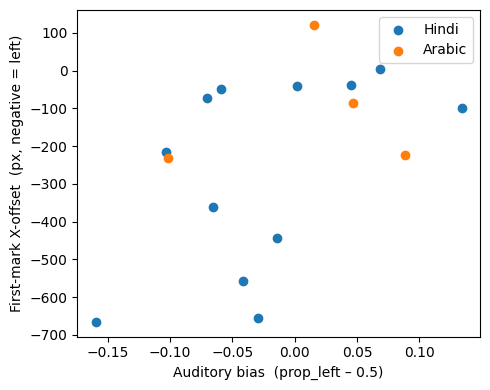


Epicentre X-offset: n=16,  Pearson r=0.01 (p=0.9812),  Spearman ρ=-0.02 (p=0.9483)


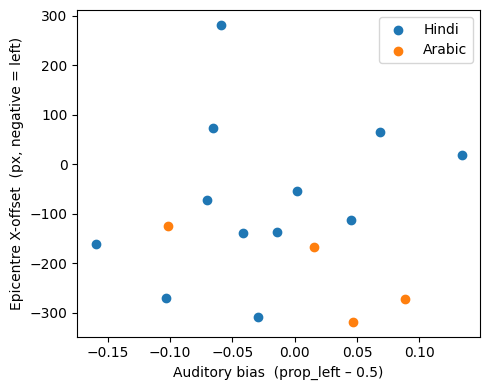

In [ ]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from scipy import stats

# ---------------------------------------------------------------
# 0. Load & tidy
# ---------------------------------------------------------------
df["language_group"] = df["language_group"].str.strip().str.title()
if "participant_id" not in df.columns:
    df["participant_id"] = np.arange(len(df))

# ---------------------------------------------------------------
# 1. Auditory MS bias  = mean(prop_left) – 0.5   (negative = left)
# ---------------------------------------------------------------
aud_cols = [f"prop_left_{i}" for i in range(1, 7)]
df["audio_bias"] = df[aud_cols].mean(axis=1, skipna=True) - 0.5

# ---------------------------------------------------------------
# 2. Cancellation bias  – choice A: first-mark offsets
#    (relative to 960-px centre) averaged across matrices
# ---------------------------------------------------------------
CENTRE = 960
for m in (1, 2, 3):
    df[f"first_off{m}"] = df[f"first_x_mat{m}"] - CENTRE
df["cancel_bias_first"] = df[[f"first_off{m}" for m in (1, 2, 3)]].mean(axis=1, skipna=True)

# 2b. Optional choice B: subjective epicentre offsets
for m in (1, 2, 3):
    df[f"epi_off{m}"] = df[f"epicenter_x_mat{m}"] - CENTRE
df["cancel_bias_epi"] = df[[f"epi_off{m}" for m in (1, 2, 3)]].mean(axis=1, skipna=True)

# ---------------------------------------------------------------
# 3. Correlations (Pearson + Spearman)  – choose metric
# ---------------------------------------------------------------
def corr_summary(metric):
    d = df[["participant_id", "language_group", "audio_bias", metric]].dropna()
    r, p = stats.pearsonr(d["audio_bias"], d[metric])
    ρ, pρ = stats.spearmanr(d["audio_bias"], d[metric])
    return len(d), r, p, ρ, pρ, d

for metric, label in [("cancel_bias_first", "First-mark X-offset"),
                      ("cancel_bias_epi",   "Epicentre X-offset")]:
    n, r, p, rho, prho, dplot = corr_summary(metric)
    print(f"\n{label}: n={n},  Pearson r={r:.2f} (p={p:.4f}),  "
          f"Spearman ρ={rho:.2f} (p={prho:.4f})")

    # quick scatter
    plt.figure(figsize=(5,4))
    for grp, col in zip(["Hindi","Arabic"], ["tab:blue","tab:orange"]):
        s = dplot[dplot["language_group"]==grp]
        plt.scatter(s["audio_bias"], s[metric], label=grp, color=col)
    plt.xlabel("Auditory bias  (prop_left – 0.5)")
    plt.ylabel(label + "  (px, negative = left)")
    plt.legend(); plt.tight_layout(); plt.show()



First-mark X-offset: n=16,  Pearson r=0.49 (p=0.0550),  Spearman ρ=0.46 (p=0.0738)


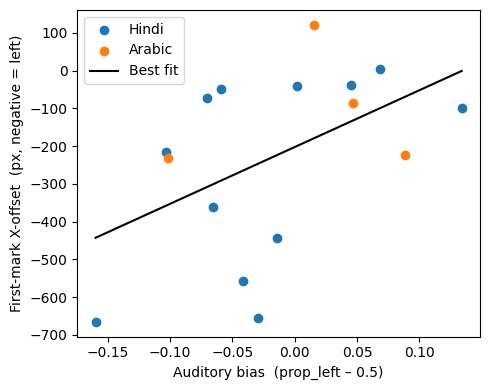


Epicentre X-offset: n=16,  Pearson r=0.01 (p=0.9812),  Spearman ρ=-0.02 (p=0.9483)


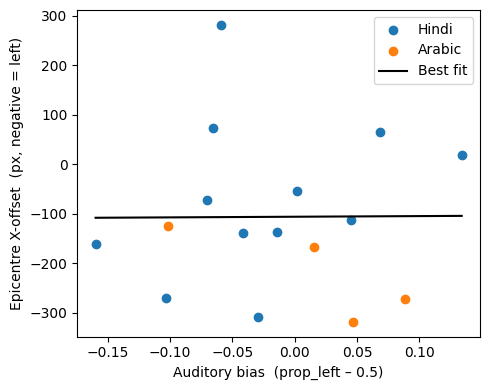

In [ ]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from scipy import stats

# ---------------------------------------------------------------
# 0. Load & tidy
# ---------------------------------------------------------------
df["language_group"] = df["language_group"].str.strip().str.title()
if "participant_id" not in df.columns:
    df["participant_id"] = np.arange(len(df))

# ---------------------------------------------------------------
# 1. Auditory MS bias  = mean(prop_left) – 0.5   (negative = left)
# ---------------------------------------------------------------
aud_cols = [f"prop_left_{i}" for i in range(1, 7)]
df["audio_bias"] = df[aud_cols].mean(axis=1, skipna=True) - 0.5

# ---------------------------------------------------------------
# 2. Cancellation bias  – choice A: first-mark offsets
# ---------------------------------------------------------------
CENTRE = 960
for m in (1, 2, 3):
    df[f"first_off{m}"] = df[f"first_x_mat{m}"] - CENTRE
df["cancel_bias_first"] = df[[f"first_off{m}" for m in (1, 2, 3)]].mean(axis=1, skipna=True)

# 2b. Optional choice B: subjective epicentre offsets
for m in (1, 2, 3):
    df[f"epi_off{m}"] = df[f"epicenter_x_mat{m}"] - CENTRE
df["cancel_bias_epi"] = df[[f"epi_off{m}" for m in (1, 2, 3)]].mean(axis=1, skipna=True)

# ---------------------------------------------------------------
# 3. Correlations (Pearson + Spearman)  – choose metric
# ---------------------------------------------------------------
def corr_summary(metric):
    d = df[["participant_id", "language_group", "audio_bias", metric]].dropna()
    r, p = stats.pearsonr(d["audio_bias"], d[metric])
    ρ, pρ = stats.spearmanr(d["audio_bias"], d[metric])
    return len(d), r, p, ρ, pρ, d

for metric, label in [("cancel_bias_first", "First-mark X-offset"),
                      ("cancel_bias_epi",   "Epicentre X-offset")]:
    n, r, p, rho, prho, dplot = corr_summary(metric)
    print(f"\n{label}: n={n},  Pearson r={r:.2f} (p={p:.4f}),  "
          f"Spearman ρ={rho:.2f} (p={prho:.4f})")

    # quick scatter
    plt.figure(figsize=(5,4))
    for grp, col in zip(["Hindi","Arabic"], ["tab:blue","tab:orange"]):
        s = dplot[dplot["language_group"]==grp]
        plt.scatter(s["audio_bias"], s[metric], label=grp, color=col)

    # —— add line of best fit —— #
    slope, intercept, r_val, p_val, std_err = stats.linregress(
        dplot["audio_bias"], dplot[metric]
    )
    x_vals = np.linspace(dplot["audio_bias"].min(), dplot["audio_bias"].max(), 100)
    y_vals = slope * x_vals + intercept
    plt.plot(x_vals, y_vals, color='black', label='Best fit')

    plt.xlabel("Auditory bias  (prop_left – 0.5)")
    plt.ylabel(label + "  (px, negative = left)")
    plt.legend()
    plt.tight_layout()
    plt.show()


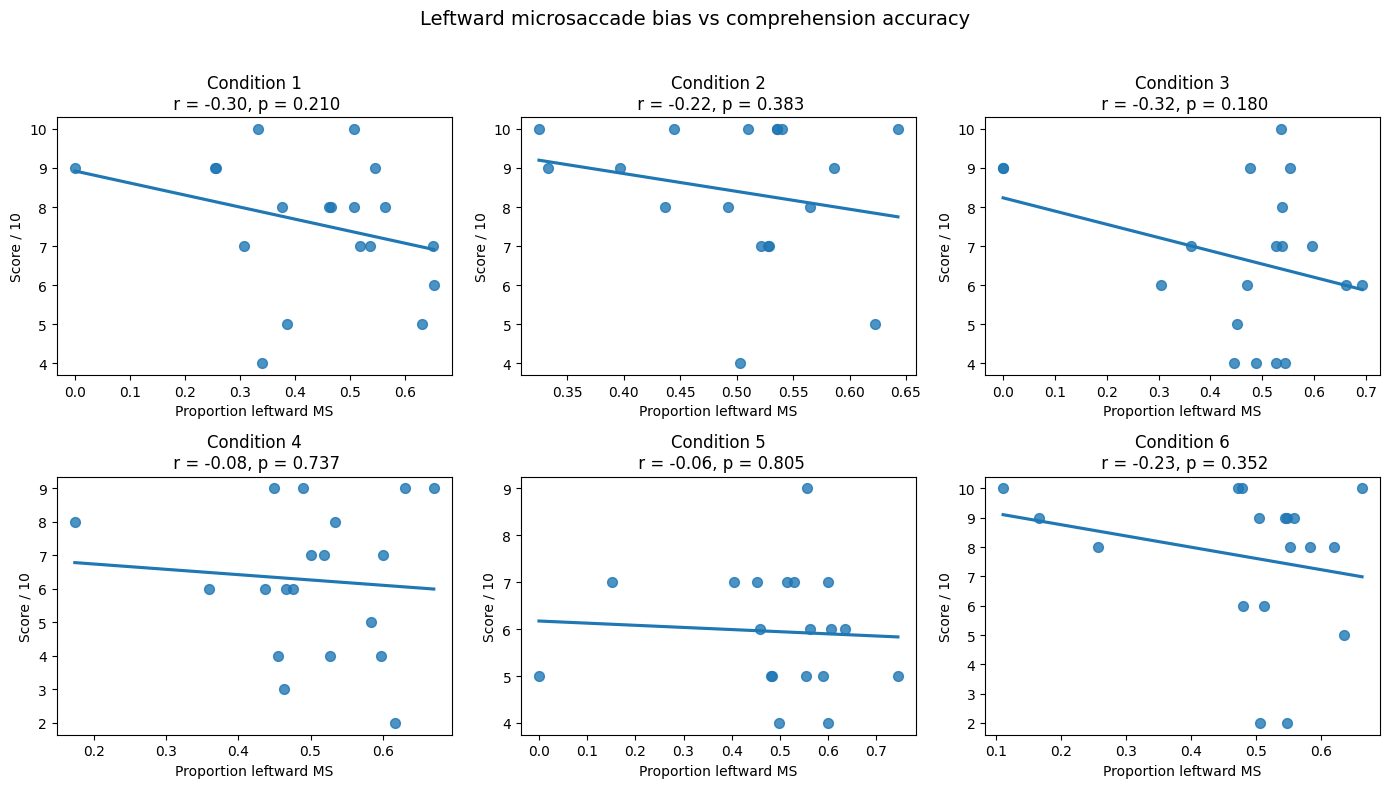


Correlation summary
   Condition   n      r      p
0          1  19 -0.301  0.210
1          2  18 -0.219  0.383
2          3  19 -0.321  0.180
3          4  19 -0.083  0.737
4          5  19 -0.061  0.805
5          6  18 -0.233  0.352

Overall: n = 112, r = -0.19, p = 0.0399


In [ ]:
# ===============================================================
# 0. Imports & mapping dictionaries
# ===============================================================
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

arabic_ptp_num = {"01":"3","02":"4","03":"8","04":"14","05":"15"}
hindi_ptp_num  = {"01":"1","02":"2","03":"5","04":"6","05":"7","06":"9","07":"10",
                  "08":"11","09":"12","10":"13","11":"16","12":"17","13":"18","14":"19"}
mapping_dicts  = {"Arabic": arabic_ptp_num, "Hindi": hindi_ptp_num}

# ===============================================================
# 1. Load both datasets
# ===============================================================
beh = pd.read_csv(r"F:\01_Academic\Disseration\Post_EXP\Preprocessing\Auditory_Speech_Task\Raw_Data\Beh_Comp_RAW\Beh_Comp_RAW.csv")
ms  = pd.read_csv(r"F:\01_Academic\Disseration\Post_EXP\Preprocessing\Auditory_Speech_Task\High-Level_Feature_Extraction\Auditory_Speech_High-Level_Features")

# keep only the columns we need from ms
ms = ms[['participant_id', 'condition', 'prop_leftward']]

# ===============================================================
# 2. Map the within-group IDs → global IDs in the behavioural DF
# ===============================================================
def map_id(row):
    group = row['experimental_group']
    within = f"{int(row['participant_id']):02d}"   # e.g. 1 → "01"
    return mapping_dicts[group].get(within, np.nan)

beh['global_id'] = beh.apply(map_id, axis=1).astype(float)

# drop rows where mapping failed
beh = beh.dropna(subset=['global_id'])

# ===============================================================
# 3. Aggregate: score /10 per participant × condition
# ===============================================================
score = (beh.groupby(['global_id', 'experimental_condition'])
            ['correct_answers']
            .sum()
            .reset_index()
            .rename(columns={'global_id':'participant_id',
                             'experimental_condition':'condition',
                             'correct_answers':'score'}))

# ===============================================================
# 4. Merge with MS bias
# ===============================================================
ms = ms.rename(columns={'experimental_condition':'condition'})
merged = (score
          .merge(ms, on=['participant_id','condition'], how='inner')
          .dropna(subset=['prop_leftward']))

# ===============================================================
# 5. Correlation & scatter per condition
# ===============================================================
plt.style.use('default')
fig, axes = plt.subplots(2, 3, figsize=(14, 8), sharex=False, sharey=False)
axes = axes.ravel()

summary = []

for cond in sorted(merged['condition'].unique()):
    sub = merged[merged['condition']==cond]
    r, p = stats.pearsonr(sub['prop_leftward'], sub['score'])
    summary.append({'Condition': cond, 'n':len(sub), 'r':r, 'p':p})

    ax = axes[cond-1]
    sns.regplot(x='prop_leftward', y='score', data=sub,
                ax=ax, scatter_kws=dict(s=50), ci=None)
    ax.set_title(f'Condition {cond}\n r = {r:.2f}, p = {p:.3f}')
    ax.set_xlabel('Proportion leftward MS')
    ax.set_ylabel('Score / 10')

fig.suptitle('Leftward microsaccade bias vs comprehension accuracy', fontsize=14)
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

# ===============================================================
# 6. Overall correlation (all conditions stacked)
# ===============================================================
r_all, p_all = stats.pearsonr(merged['prop_leftward'], merged['score'])
print("\nCorrelation summary")
print(pd.DataFrame(summary).round(3))
print(f"\nOverall: n = {len(merged)}, r = {r_all:.2f}, p = {p_all:.4f}")



OVERALL  (n=112)   Pearson r=-0.19 (p=0.0399)   Spearman ρ=-0.13 (p=0.1576)

PER-CONDITION correlations
   Condition   n  Pearson_r     p_r  Spearman_rho   p_rho
0          1  19      -0.30  0.2101         -0.38  0.1060
1          2  18      -0.22  0.3830         -0.03  0.9094
2          3  19      -0.32  0.1796         -0.06  0.7964
3          4  19      -0.08  0.7370          0.06  0.8115
4          5  19      -0.06  0.8052         -0.16  0.5171
5          6  18      -0.23  0.3523         -0.28  0.2574

PER-LANGUAGE correlations
  Language   n  Pearson_r     p_r  Spearman_rho   p_rho
0    Hindi  82      -0.19  0.0893         -0.13  0.2613
1   Arabic  30      -0.24  0.1973         -0.19  0.3196


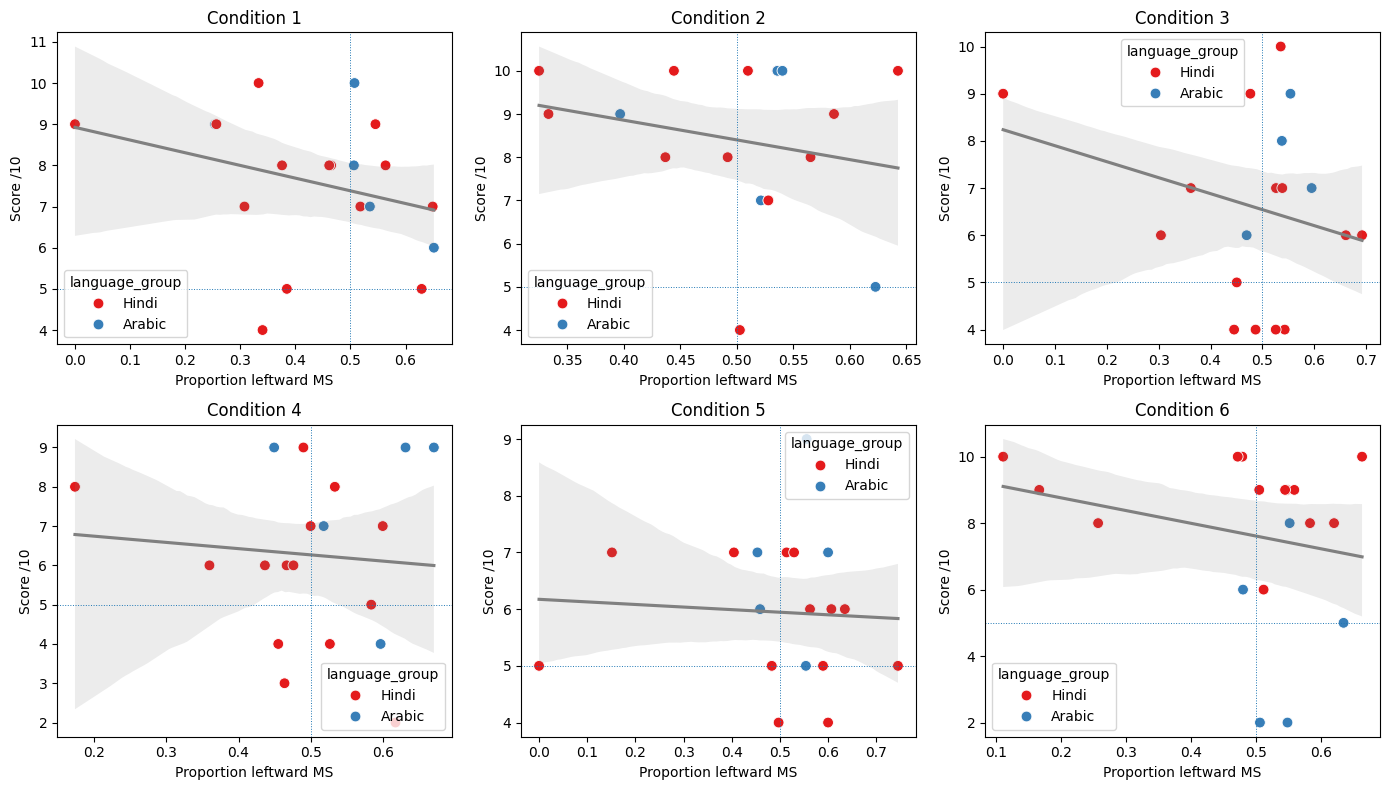

In [ ]:
# ===============================================================
# 0. Imports & ID-mapping dictionaries
# ===============================================================
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt
from scipy import stats

arabic_ptp_num = {"01":"3","02":"4","03":"8","04":"14","05":"15"}
hindi_ptp_num  = {"01":"1","02":"2","03":"5","04":"6","05":"7","06":"9","07":"10",
                  "08":"11","09":"12","10":"13","11":"16","12":"17",
                  "13":"18","14":"19"}
mapping_dicts = {"Arabic": arabic_ptp_num, "Hindi": hindi_ptp_num}

# ----------- build a reverse map {global_id: language} ----------
global_to_lang = {v: "Arabic" for v in arabic_ptp_num.values()}
global_to_lang.update({v: "Hindi" for v in hindi_ptp_num.values()})

# ===============================================================
# 1. Load both datasets
# ===============================================================
beh = pd.read_csv(r"F:\01_Academic\Disseration\Post_EXP\Preprocessing\Auditory_Speech_Task\Raw_Data\Beh_Comp_RAW\Beh_Comp_RAW.csv")
ms  = pd.read_csv(r"F:\01_Academic\Disseration\Post_EXP\Preprocessing\Auditory_Speech_Task\High-Level_Feature_Extraction\Auditory_Speech_High-Level_Features    ")

# ===============================================================
# 2. Map within-group IDs → global IDs in behavioural DF
# ===============================================================
def to_global(row):
    group = row['experimental_group']
    within = f"{int(row['participant_id']):02d}"
    return mapping_dicts[group].get(within, np.nan)

beh['participant_id'] = beh.apply(to_global, axis=1).astype(float)
beh = beh.dropna(subset=['participant_id'])

# keep what we need
beh = beh[['participant_id','experimental_condition','correct_answers']]

# ===============================================================
# 3. Add language label to MS dataframe using the reverse map
# ===============================================================
ms['language_group'] = ms['participant_id'].astype(int).astype(str).map(global_to_lang)
ms = ms.rename(columns={'experimental_condition':'condition'})
ms = ms[['participant_id','condition','prop_leftward','language_group']]

# ===============================================================
# 4. Compute score / 10 per participant × condition
# ===============================================================
score = (beh.groupby(['participant_id','experimental_condition'])
            ['correct_answers'].sum()
            .reset_index()
            .rename(columns={'experimental_condition':'condition',
                             'correct_answers':'score'}))

# ===============================================================
# 5. Merge bias + accuracy
# ===============================================================
merged = (score.merge(ms, on=['participant_id','condition'], how='inner')
                .dropna(subset=['prop_leftward','language_group']))

# ===============================================================
# 6. Correlation helper
# ===============================================================
def corr(df):
    if len(df) < 3:
        return np.nan, np.nan, np.nan, np.nan, len(df)
    r , p  = stats.pearsonr(df['prop_leftward'], df['score'])
    rho, pr = stats.spearmanr(df['prop_leftward'], df['score'])
    return r, p, rho, pr, len(df)

# 6a Overall
r, p, rho, pr, n = corr(merged)
print(f"\nOVERALL  (n={n})   Pearson r={r:.2f} (p={p:.4f})   "
      f"Spearman ρ={rho:.2f} (p={pr:.4f})")

# 6b Per condition
rows_c = []
for c in sorted(merged['condition'].unique()):
    r, p, rho, pr, n = corr(merged[merged['condition']==c])
    rows_c.append(dict(Condition=c, n=n, 
                       Pearson_r=r, p_r=p,
                       Spearman_rho=rho, p_rho=pr))
print("\nPER-CONDITION correlations")
print(pd.DataFrame(rows_c)
        .round({'Pearson_r':2,'p_r':4,'Spearman_rho':2,'p_rho':4}))

# 6c Per language (all conditions pooled)
rows_l = []
for lang in ['Hindi','Arabic']:
    r, p, rho, pr, n = corr(merged[merged['language_group']==lang])
    rows_l.append(dict(Language=lang, n=n,
                       Pearson_r=r, p_r=p,
                       Spearman_rho=rho, p_rho=pr))
print("\nPER-LANGUAGE correlations")
print(pd.DataFrame(rows_l)
        .round({'Pearson_r':2,'p_r':4,'Spearman_rho':2,'p_rho':4}))

# ===============================================================
# 7. Scatter-plots per condition, colour = language
# ===============================================================
plt.figure(figsize=(14,8))
for i, c in enumerate(sorted(merged['condition'].unique()), 1):
    plt.subplot(2,3,i)
    sns.scatterplot(data=merged[merged['condition']==c],
                    x='prop_leftward', y='score',
                    hue='language_group', palette='Set1', s=60)
    sns.regplot(data=merged[merged['condition']==c],
                x='prop_leftward', y='score',
                scatter=False, color='grey')
    plt.axhline(5, ls=':', lw=.7); plt.axvline(0.5, ls=':', lw=.7)
    plt.title(f'Condition {c}')
    plt.xlabel('Proportion leftward MS')
    plt.ylabel('Score /10')
plt.tight_layout(); plt.show()



OVERALL comprehension scores:
          M    SD      N
score  7.07  2.07  112.0

By language:
                   M    SD   N
language_group                
Arabic          7.17  2.17  30
Hindi           7.04  2.05  82

By language × condition:
                             M    SD   N
language_group condition                
Arabic         1          8.00  1.58   5
               2          8.20  2.17   5
               3          7.80  1.30   5
               4          7.60  2.19   5
               5          6.80  1.48   5
               6          4.60  2.61   5
Hindi          1          7.43  1.74  14
               2          8.46  1.76  13
               3          6.29  2.02  14
               4          5.79  2.01  14
               5          5.64  1.08  14
               6          8.85  1.14  13

CORRELATIONS between leftward MS bias and comprehension score
   Sample    n  Pearson_r     p_r  Spearman_rho   p_rho
0     All  112      -0.19  0.0399         -0.13  0.1576
1   Hi

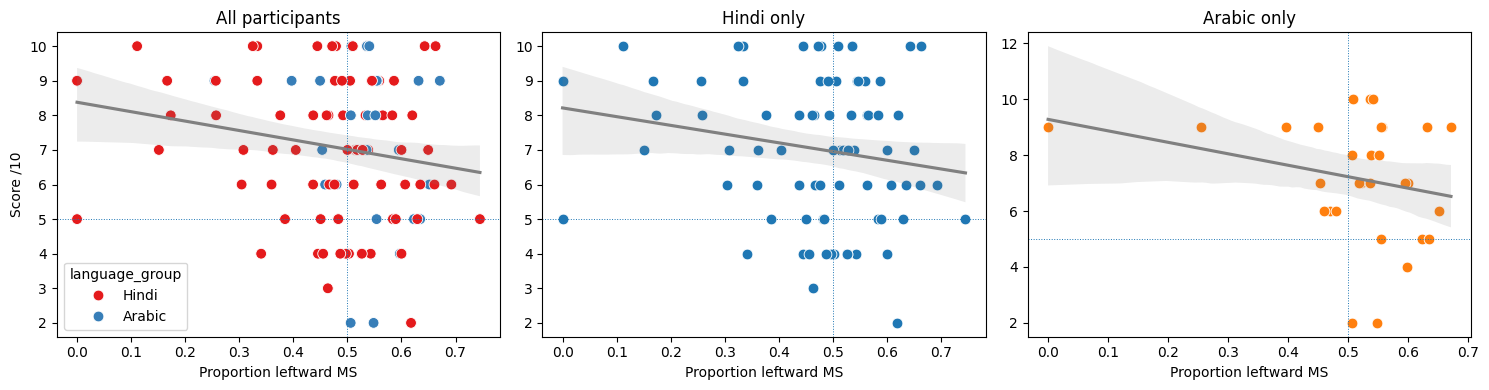

In [ ]:
# ===============================================================
# 0.  Descriptive statistics for comprehension accuracy
# ===============================================================
print("\nOVERALL comprehension scores:")
overall_desc = merged['score'].agg(['mean','std','count']).round(2).rename({
    'mean':'M','std':'SD','count':'N'})
print(overall_desc.to_frame().T)

print("\nBy language:")
lang_desc = (merged.groupby('language_group')['score']
                   .agg(M='mean', SD='std', N='count')
                   .round(2))
print(lang_desc)

print("\nBy language × condition:")
lang_cond_desc = (merged.groupby(['language_group','condition'])['score']
                        .agg(M='mean', SD='std', N='count')
                        .round(2))
print(lang_cond_desc)

# ===============================================================
# 1.  Correlations: overall and per language
# ===============================================================
def corrs(df):
    r , p  = stats.pearsonr(df['prop_leftward'], df['score'])
    rho, pr = stats.spearmanr(df['prop_leftward'], df['score'])
    return r, p, rho, pr, len(df)

print("\nCORRELATIONS between leftward MS bias and comprehension score")
rows=[]
for label, sub in [('All', merged),
                   ('Hindi', merged[merged['language_group']=='Hindi']),
                   ('Arabic', merged[merged['language_group']=='Arabic'])]:
    r,p,rho,pr,n = corrs(sub)
    rows.append(dict(Sample=label, n=n,
                     Pearson_r=round(r,2), p_r=round(p,4),
                     Spearman_rho=round(rho,2), p_rho=round(pr,4)))
print(pd.DataFrame(rows))

# ===============================================================
# 2.  Scatter-plots  (overall + by-language)
# ===============================================================
plt.figure(figsize=(15,4))

# Overall
plt.subplot(1,3,1)
sns.scatterplot(data=merged, x='prop_leftward', y='score',
                hue='language_group', palette='Set1', s=60)
sns.regplot(data=merged, x='prop_leftward', y='score',
            scatter=False, color='grey')
plt.title('All participants')
plt.xlabel('Proportion leftward MS'); plt.ylabel('Score /10')
plt.axhline(5, ls=':', lw=.7); plt.axvline(0.5, ls=':', lw=.7)

# Hindi
plt.subplot(1,3,2)
sub = merged[merged['language_group']=='Hindi']
sns.scatterplot(data=sub, x='prop_leftward', y='score', color='tab:blue', s=60)
sns.regplot(data=sub, x='prop_leftward', y='score',
            scatter=False, color='grey')
plt.title('Hindi only')
plt.xlabel('Proportion leftward MS'); plt.ylabel('')
plt.axhline(5, ls=':', lw=.7); plt.axvline(0.5, ls=':', lw=.7)

# Arabic
plt.subplot(1,3,3)
sub = merged[merged['language_group']=='Arabic']
sns.scatterplot(data=sub, x='prop_leftward', y='score', color='tab:orange', s=60)
sns.regplot(data=sub, x='prop_leftward', y='score',
            scatter=False, color='grey')
plt.title('Arabic only')
plt.xlabel('Proportion leftward MS'); plt.ylabel('')
plt.axhline(5, ls=':', lw=.7); plt.axvline(0.5, ls=':', lw=.7)

plt.tight_layout(); plt.show()


In [ ]:
import numpy as np
hindi_lang_prof = np.mean([6.33, 7.33, 10, 8.33, 9, 9.66, 9, 8.66, 9.33, 8.66, 7.66])

arabic_lang_prof = np.mean([7.33, 8, 8.33, 9.66, 9.33])

print(hindi_lang_prof)
print(arabic_lang_prof)

8.541818181818181
8.53


In [ ]:
import pandas as pd
import numpy as np

# ---------------------------------------------------------------
# 1. Load the dataset
# ---------------------------------------------------------------
df = pd.read_csv(r"F:\01_Academic\Disseration\Post_EXP\Preprocessing\EXP_Log\EXP_Log.csv")   # adjust path if needed

# ---------------------------------------------------------------
# 2. Clean columns
# ---------------------------------------------------------------
# Ensure numeric Age
df["Age"] = pd.to_numeric(df["Age"], errors="coerce")

# Standardise language labels so there is ONE “Hindi” and ONE “Arabic”
df["Language Group"] = (df["Language Group"]
                        .astype(str)
                        .str.strip()        # remove stray spaces
                        .str.title())       # e.g. "hindi " → "Hindi"

# ---------------------------------------------------------------
# 3. Overall descriptives
# ---------------------------------------------------------------
overall_mean = df["Age"].mean()
overall_sd   = df["Age"].std(ddof=1)
overall_sex  = (df["Sex"]
                .fillna("Missing")
                .value_counts()
                .rename("N"))

print(f"\nOVERALL (N = {len(df)})")
print(f"Mean age = {overall_mean:.2f}  (SD = {overall_sd:.2f})")
print("Sex counts:\n", overall_sex.to_frame())

# ---------------------------------------------------------------
# 4. By language group
# ---------------------------------------------------------------
# 4a Age mean & SD
age_stats = (df.groupby("Language Group")["Age"]
               .agg(N="count", Mean="mean", SD=("std"))
               .round({"Mean": 2, "SD": 2}))
print("\nBY LANGUAGE – Age")
print(age_stats)

# 4b Sex counts
sex_counts = (df.groupby("Language Group")["Sex"]
                .value_counts(dropna=False)
                .unstack(fill_value=0)
                .astype(int))
print("\nBY LANGUAGE – Sex counts")
print(sex_counts)



OVERALL (N = 81)
Mean age = 22.65  (SD = 3.75)
Sex counts:
           N
Sex        
Missing  61
F        14
M         6

BY LANGUAGE – Age
                 N   Mean    SD
Language Group                 
Arabic           5  20.20  0.84
Hindi           15  23.47  4.00
Nan              0    NaN   NaN

BY LANGUAGE – Sex counts
Sex              F  M  NaN
Language Group            
Arabic           4  1    0
Hindi           10  5    0
Nan              0  0   61
